In [23]:
  pip install opencv-python matplotlib imageio gdown tensorflow 

Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import tensorflow_hub as hub

In [25]:
import gdown

In [26]:
url="https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
output="data.zip"
gdown.download(url,output,quiet=False)
gdown.extractall("data.zip")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=3e33f9c3-77be-4879-87f2-fd38642aa90f
To: /kaggle/working/data.zip
100%|██████████| 423M/423M [00:01<00:00, 228MB/s]  


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [27]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [28]:
vocab=[x for x in "abcdefghijklmnopqrstuvwxyz'!?1234567890 "]

In [29]:
char_to_num=tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True)
print(f"The vocabulary is:{char_to_num.get_vocabulary()}" 
      f"(size={char_to_num.vocabulary_size()})")

The vocabulary is:['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '!', '?', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', ' '](size=41)


In [30]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:] 

In [31]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split("/")[-1].split(".")[0]
    video_path=os.path.join("data","s1",f"{file_name}.mpg")
    alignment_path=os.path.join("data","alignments","s1",f"{file_name}.align")
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    return frames,alignments

In [32]:
test_path="./data/s1/bbal6n.mpg"

In [33]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [34]:
frames,alignments=load_data(tf.convert_to_tensor(test_path))
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.19734783],
         [ 0.07893913]],

        [[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209044 ],
         [ 1.4209044 ],
         [ 1.3814349 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.946331  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.86739

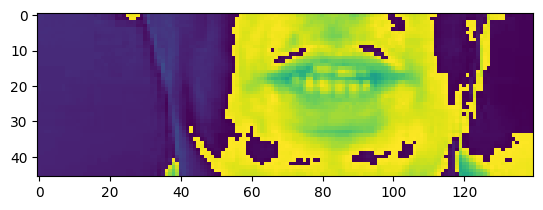

In [35]:
plt.imshow(frames[40])

In [36]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [37]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [38]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [39]:
train = data.take(450)
test = data.skip(450)

In [40]:
frames,alignments=data.as_numpy_iterator().next()

In [41]:
len(frames)

2

In [42]:
sample=data.as_numpy_iterator()

In [43]:
val=sample.next();val[0]

array([[[[[ 1.4711899 ],
          [ 1.5429552 ],
          [ 1.5788379 ],
          ...,
          [ 0.3229441 ],
          [ 0.3588268 ],
          [ 0.3588268 ]],

         [[ 1.5429552 ],
          [ 1.6147206 ],
          [ 1.5429552 ],
          ...,
          [ 0.3229441 ],
          [ 0.3588268 ],
          [ 0.3588268 ]],

         [[ 1.4353071 ],
          [ 1.4353071 ],
          [ 1.4353071 ],
          ...,
          [ 0.39470947],
          [ 0.3588268 ],
          [ 0.3588268 ]],

         ...,

         [[ 1.0405977 ],
          [ 1.0405977 ],
          [ 1.004715  ],
          ...,
          [ 0.10764804],
          [ 0.10764804],
          [ 0.07176536]],

         [[ 1.0405977 ],
          [ 1.0405977 ],
          [ 1.004715  ],
          ...,
          [ 0.07176536],
          [ 0.07176536],
          [ 0.03588268]],

         [[ 1.0405977 ],
          [ 1.0405977 ],
          [ 1.004715  ],
          ...,
          [ 0.03588268],
          [ 0.03588268],
          

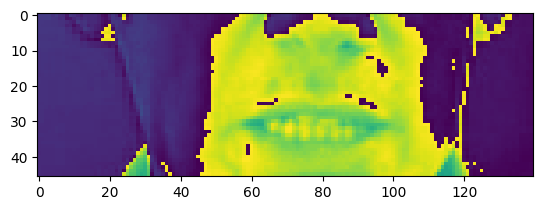

In [44]:
plt.imshow(val[0][0][35])

In [45]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white at u eight now'>

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D,LSTM,Dense,Dropout,Bidirectional,MaxPool3D,Activation,Reshape,SpatialDropout3D,BatchNormalization,TimeDistributed,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler

In [47]:
model=Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3,padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128,kernel_initializer='Orthogonal',return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128,kernel_initializer='Orthogonal',return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1,kernel_initializer="he_normal",activation="softmax"))

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [49]:
5*17*75

6375

In [50]:
yhat=model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [51]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'777777777777777777777777777777777777777777777777777777777777777777777777777'>

In [52]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'777777777777777777777777777777777777777777777777777777777777777777777777777'>

In [53]:
model.input_shape

(None, 75, 46, 140, 1)

In [54]:
model.output_shape

(None, 75, 42)

In [55]:
def scheduler(epcoh,lr):
    if epcoh<30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [56]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [57]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self,dataset)->None:
        self.dataset=dataset.as_numpy_iterator()
    def on_epoch_end(self,epoch,log=None)->None:
        data=self.dataset.next()
        yhat=self.model.predict(data[0])
        decoded=tf.keras.backend.ctc_decode(yhat,[75,75],greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print("Original:",tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode("utf-8"))
            print("prediction",tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode("utf-8"))
            print("~"*100)

In [58]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss)
checkpoint_callback=ModelCheckpoint(os.path.join("model","checkPoint"),monitor="loss",save_weights_only=True)
schedule_callback=LearningRateScheduler(scheduler)
example_callback=ProduceExample(test)
model.fit(train,validation_data=test,epochs=50,callbacks=[checkpoint_callback,schedule_callback,example_callback])

Epoch 1/50
273/450 [=================>............] - ETA: 2:04 - loss: 90.2386

[mpeg1video @ 0x7c3540001680] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3540001680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 84.6675

[mpeg1video @ 0x7c3474056e40] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3474056e40] Warning MVs not available
[mpeg1video @ 0x7c2fac0026c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fac0026c0] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: lay blue by y four please
prediction le e e e e n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white in r four please
prediction l e e e e n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 754s 2s/step - loss: 84.6675 - val_loss: 71.1232 - lr: 1.0000e-04
Epoch 2/50
163/450 [=========>....................] - ETA: 3:23 - loss: 72.5116

[mpeg1video @ 0x7c33e4036780] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33e4036780] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 71.5884

[mpeg1video @ 0x7c3538051ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3538051ac0] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: lay red with r eight now
prediction la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white by k two please
prediction le e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 542s 1s/step - loss: 71.5884 - val_loss: 67.3006 - lr: 1.0000e-04
Epoch 3/50
327/450 [====================>.........] - ETA: 1:27 - loss: 68.0991

[mpeg1video @ 0x7c2f082db680] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f082db680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 67.5530

[mpeg1video @ 0x7c346c015840] ac-tex damaged at 22 17
[mpeg1video @ 0x7c346c015840] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: bin red with g six now
prediction la e e t e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green in b nine soon
prediction la e e t e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 540s 1s/step - loss: 67.5530 - val_loss: 63.0789 - lr: 1.0000e-04
Epoch 4/50
323/450 [====================>.........] - ETA: 1:29 - loss: 65.0595

[mpeg1video @ 0x7c3394076cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3394076cc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 64.7207

[mpeg1video @ 0x7c33d4011280] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33d4011280] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: bin green with o four please
prediction la e e e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with l zero now
prediction la e e e oa
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 538s 1s/step - loss: 64.7207 - val_loss: 60.4072 - lr: 1.0000e-04
Epoch 5/50
 59/450 [==>...........................] - ETA: 4:34 - loss: 63.7708

[mpeg1video @ 0x7c2f95e79380] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f95e79380] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 62.6710

[mpeg1video @ 0x7c2f082db680] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f082db680] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: place blue with j two now
prediction la re i e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue in u eight now
prediction la re t e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 541s 1s/step - loss: 62.6710 - val_loss: 58.0905 - lr: 1.0000e-04
Epoch 6/50
168/450 [==========>...................] - ETA: 3:18 - loss: 61.6070

[mpeg1video @ 0x7c354002bd80] ac-tex damaged at 22 17
[mpeg1video @ 0x7c354002bd80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 61.0993

[mpeg1video @ 0x7c2f9c099440] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f9c099440] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: set white by i five soon
prediction la re i e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with k six please
prediction la re i e aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 546s 1s/step - loss: 61.0993 - val_loss: 56.9664 - lr: 1.0000e-04
Epoch 7/50
281/450 [=================>............] - ETA: 2:00 - loss: 59.8831

[mpeg1video @ 0x7c347419ecc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c347419ecc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 59.7734

[mpeg1video @ 0x7c3550063380] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3550063380] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: place green in k zero please
prediction la re t e eon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green with q one again
prediction la re t e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 545s 1s/step - loss: 59.7734 - val_loss: 56.4704 - lr: 1.0000e-04
Epoch 8/50
450/450 [==============================] - ETA: 0s - loss: 58.3924

[mpeg1video @ 0x7c35380033c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c35380033c0] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Original: bin white in t one again
prediction la re t e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue at i five soon
prediction la re t e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 544s 1s/step - loss: 58.3924 - val_loss: 55.2499 - lr: 1.0000e-04
Epoch 9/50
120/450 [=======>......................] - ETA: 3:53 - loss: 57.5468

[mpeg1video @ 0x7c33a86a8280] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33a86a8280] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 56.5289

[mpeg1video @ 0x7c3484066f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3484066f00] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: place blue by p two now
prediction la re t e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue at d eight please
prediction la re t e aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 544s 1s/step - loss: 56.5289 - val_loss: 52.6134 - lr: 1.0000e-04
Epoch 10/50
339/450 [=====================>........] - ETA: 1:18 - loss: 53.7365

[mpeg1video @ 0x7c2fac0334c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fac0334c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 53.4878

[mpeg1video @ 0x7c33d405c9c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33d405c9c0] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: place green in q five again
prediction la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white with j one again
prediction la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 543s 1s/step - loss: 53.4878 - val_loss: 50.7366 - lr: 1.0000e-04
Epoch 11/50
122/450 [=======>......................] - ETA: 3:51 - loss: 51.7822

[mpeg1video @ 0x7c2f980a7c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f980a7c80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 52.1335

[mpeg1video @ 0x7c2f13ea9480] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f13ea9480] Warning MVs not available


1/1 [==============================] - 0s 123ms/step
Original: lay red in k two now
prediction la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at i nine again
prediction la re t e aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 543s 1s/step - loss: 52.1335 - val_loss: 48.1214 - lr: 1.0000e-04
Epoch 12/50
272/450 [=================>............] - ETA: 2:06 - loss: 50.5691

[mpeg1video @ 0x7c3534042a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3534042a40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 50.5530

[mpeg1video @ 0x7c2fa40aa300] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fa40aa300] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place white in p six now
prediction pla re n o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white sp by n four please
prediction la re t e ae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 543s 1s/step - loss: 50.5530 - val_loss: 47.2202 - lr: 1.0000e-04
Epoch 13/50
450/450 [==============================] - ETA: 0s - loss: 48.8683

[mpeg1video @ 0x7c35480514c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c35480514c0] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: bin green at t nine soon
prediction plac re i o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with h seven soon
prediction pla bre i o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 544s 1s/step - loss: 48.8683 - val_loss: 45.2821 - lr: 1.0000e-04
Epoch 14/50
438/450 [============================>.] - ETA: 8s - loss: 47.5106

[mpeg1video @ 0x7c33b4065900] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33b4065900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 47.5153

[mpeg1video @ 0x7c3534045440] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3534045440] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: bin green with b six please
prediction la re i e plae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with a five again
prediction la re i ie an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 540s 1s/step - loss: 47.5153 - val_loss: 42.4170 - lr: 1.0000e-04
Epoch 15/50
217/450 [=============>................] - ETA: 2:44 - loss: 45.8209

[mpeg1video @ 0x7c2f4aaaa900] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f4aaaa900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 45.7285

[mpeg1video @ 0x7c33dc063bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33dc063bc0] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: place green in x seven soon
prediction bla wre it ie o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue by p three soon
prediction la re it ne on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 541s 1s/step - loss: 45.7285 - val_loss: 40.6418 - lr: 1.0000e-04
Epoch 16/50
 94/450 [=====>........................] - ETA: 4:10 - loss: 44.3406

[mpeg1video @ 0x7c2f9400c000] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f9400c000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 43.8085

[mpeg1video @ 0x7c33ac00e180] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33ac00e180] Warning MVs not available


1/1 [==============================] - 0s 128ms/step
Original: lay white in e five soon
prediction sla re it o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red by e eight please
prediction lac bre b ie plae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 539s 1s/step - loss: 43.8085 - val_loss: 38.7872 - lr: 1.0000e-04
Epoch 17/50
 66/450 [===>..........................] - ETA: 4:29 - loss: 42.5366

[mpeg1video @ 0x7c354c01ab00] ac-tex damaged at 22 17
[mpeg1video @ 0x7c354c01ab00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 42.1281

[mpeg1video @ 0x7c33a2bf1a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33a2bf1a40] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: bin red sp by g two now
prediction la re i ie o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue at x nine soon
prediction lac re it ie on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 543s 1s/step - loss: 42.1281 - val_loss: 37.4916 - lr: 1.0000e-04
Epoch 18/50
 52/450 [==>...........................] - ETA: 4:40 - loss: 40.2267

[mpeg1video @ 0x7c34480baf40] ac-tex damaged at 22 17
[mpeg1video @ 0x7c34480baf40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 40.1350

[mpeg1video @ 0x5d241408f200] ac-tex damaged at 22 17
[mpeg1video @ 0x5d241408f200] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: place white in x three again
prediction pla gre it ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red by h eight now
prediction bla re by ie ow
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 543s 1s/step - loss: 40.1350 - val_loss: 34.8288 - lr: 1.0000e-04
Epoch 19/50
206/450 [============>.................] - ETA: 2:52 - loss: 38.5515

[mpeg1video @ 0x7c33d40238c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33d40238c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 38.4178

[mpeg1video @ 0x7c35300a5b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7c35300a5b80] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: set white in o three again
prediction bia rie it ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white by d six now
prediction plac gre iy ie now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 544s 1s/step - loss: 38.4178 - val_loss: 33.8540 - lr: 1.0000e-04
Epoch 20/50
371/450 [=======================>......] - ETA: 56s - loss: 36.6501

[mpeg1video @ 0x7c2f4bc80580] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f4bc80580] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 36.6196

[mpeg1video @ 0x7c347403ab00] ac-tex damaged at 22 17
[mpeg1video @ 0x7c347403ab00] Warning MVs not available


1/1 [==============================] - 0s 123ms/step
Original: set blue at a six please
prediction pla blue y soplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with n two please
prediction slt re it o pease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 544s 1s/step - loss: 36.6196 - val_loss: 32.9371 - lr: 1.0000e-04
Epoch 21/50
125/450 [=======>......................] - ETA: 3:50 - loss: 34.5334

[mpeg1video @ 0x7c2f94022900] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f94022900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 34.8203

[mpeg1video @ 0x7c33b407fbc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33b407fbc0] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: lay green with g three soon
prediction la gre it e son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green by c six now
prediction slt red by ie now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 542s 1s/step - loss: 34.8203 - val_loss: 29.9474 - lr: 1.0000e-04
Epoch 22/50
 17/450 [>.............................] - ETA: 5:07 - loss: 33.4336

[mpeg1video @ 0x7c3540091dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3540091dc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 32.6798

[mpeg1video @ 0x7c2f4b677f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f4b677f40] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: place red in i six now
prediction place gre it in now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green in r nine soon
prediction lay grie it e son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 545s 1s/step - loss: 32.6798 - val_loss: 28.3452 - lr: 1.0000e-04
Epoch 23/50
228/450 [==============>...............] - ETA: 2:36 - loss: 31.2030

[mpeg1video @ 0x7c3534058940] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3534058940] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 30.9034

[mpeg1video @ 0x7c2f9400e340] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f9400e340] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place green with r four now
prediction place grie it fo ow
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red by l three again
prediction biay wre by ie again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 544s 1s/step - loss: 30.9034 - val_loss: 25.3912 - lr: 1.0000e-04
Epoch 24/50
128/450 [=======>......................] - ETA: 3:47 - loss: 28.8456

[mpeg1video @ 0x7c33dc038440] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33dc038440] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 28.8633

[mpeg1video @ 0x7c35480bdc80] ac-tex damaged at 22 17
[mpeg1video @ 0x7c35480bdc80] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: place blue in u nine soon
prediction place blue it ne son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red at f eight now
prediction sin red in ie now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 542s 1s/step - loss: 28.8633 - val_loss: 23.0336 - lr: 1.0000e-04
Epoch 25/50
423/450 [===========================>..] - ETA: 18s - loss: 26.4577

[mpeg1video @ 0x7c33ac09c140] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33ac09c140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 26.4862

[mpeg1video @ 0x7c3474026180] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3474026180] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: lay green with t zero now
prediction plac gre wth fo now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green by o zero please
prediction sin ren by or please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 539s 1s/step - loss: 26.4862 - val_loss: 20.7725 - lr: 1.0000e-04
Epoch 26/50
 81/450 [====>.........................] - ETA: 4:20 - loss: 24.4997

[mpeg1video @ 0x7c2fa4174fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fa4174fc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 24.4802

[mpeg1video @ 0x7c33d4039ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33d4039ac0] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: lay green with m nine again
prediction lay gren with nie again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white at a three again
prediction bin white at the again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 538s 1s/step - loss: 24.4802 - val_loss: 19.5544 - lr: 1.0000e-04
Epoch 27/50
267/450 [================>.............] - ETA: 2:08 - loss: 23.0318

[mpeg1video @ 0x7c2f98051840] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f98051840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 22.6393

[mpeg1video @ 0x7c2f13af6d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f13af6d80] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: bin white with a eight now
prediction bin white it ih now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white in l zero please
prediction lay white in o please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 538s 1s/step - loss: 22.6393 - val_loss: 17.6962 - lr: 1.0000e-04
Epoch 28/50
188/450 [===========>..................] - ETA: 3:03 - loss: 20.9996

[mpeg1video @ 0x7c353c045bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c353c045bc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 20.9674

[mpeg1video @ 0x7c2fa0006cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fa0006cc0] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: bin red in l nine soon
prediction bin red in ne son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at c five again
prediction set gren it ive again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 537s 1s/step - loss: 20.9674 - val_loss: 15.7618 - lr: 1.0000e-04
Epoch 29/50
 84/450 [====>.........................] - ETA: 4:15 - loss: 18.7690

[mpeg1video @ 0x7c34480917c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c34480917c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 19.4928

[mpeg1video @ 0x7c354c016a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7c354c016a00] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: set red by i one again
prediction set red by on again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at c four sp please
prediction set gre at for please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 537s 1s/step - loss: 19.4928 - val_loss: 14.2485 - lr: 1.0000e-04
Epoch 30/50
235/450 [==============>...............] - ETA: 2:30 - loss: 18.4607

[mpeg1video @ 0x7c33ac02a480] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33ac02a480] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 18.1207

[mpeg1video @ 0x7c353c04f380] ac-tex damaged at 22 17
[mpeg1video @ 0x7c353c04f380] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: place blue in v one again
prediction place blue in ne again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green at u one again
prediction bin gren at oe again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 537s 1s/step - loss: 18.1207 - val_loss: 13.1377 - lr: 1.0000e-04
Epoch 31/50
249/450 [===============>..............] - ETA: 2:20 - loss: 16.6902

[mpeg1video @ 0x7c2fac0c4900] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fac0c4900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 16.5905

[mpeg1video @ 0x7c3448037a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3448037a40] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Original: place white by k one soon
prediction place white by one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set sp blue with b three soon
prediction set blue with hre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 538s 1s/step - loss: 16.5905 - val_loss: 12.2746 - lr: 9.0484e-05
Epoch 32/50
 55/450 [==>...........................] - ETA: 4:37 - loss: 15.9035

[mpeg1video @ 0x7c2fa00a0700] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fa00a0700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 15.4159

[mpeg1video @ 0x7c33b4051d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33b4051d00] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: place green with e six now
prediction place gren with six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white in x one soon
prediction place white in ne son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 536s 1s/step - loss: 15.4159 - val_loss: 11.7166 - lr: 8.1873e-05
Epoch 33/50
255/450 [================>.............] - ETA: 2:16 - loss: 13.8808

[mpeg1video @ 0x7c354c081080] ac-tex damaged at 22 17
[mpeg1video @ 0x7c354c081080] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 14.0570

[mpeg1video @ 0x7c3394bba300] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3394bba300] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: lay red at e three soon
prediction lay red at tre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue by s five soon
prediction bin blue by fve son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 538s 1s/step - loss: 14.0570 - val_loss: 9.9558 - lr: 7.4082e-05
Epoch 34/50
331/450 [=====================>........] - ETA: 1:23 - loss: 13.3671

[mpeg1video @ 0x7c3484019000] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3484019000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 13.4068

[mpeg1video @ 0x5d2414ba5f80] ac-tex damaged at 22 17
[mpeg1video @ 0x5d2414ba5f80] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: bin white at t five again
prediction bin white at fve again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red by z one again
prediction lay red by oe again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 538s 1s/step - loss: 13.4068 - val_loss: 9.1256 - lr: 6.7032e-05
Epoch 35/50
271/450 [=================>............] - ETA: 2:11 - loss: 12.8507

[mpeg1video @ 0x7c33dc036e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33dc036e00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 12.9307

[mpeg1video @ 0x7c35380530c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c35380530c0] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: place red by x two now
prediction place red by wo now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in q zero now
prediction lay blue in zo now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 551s 1s/step - loss: 12.9307 - val_loss: 8.9932 - lr: 6.0653e-05
Epoch 36/50
409/450 [==========================>...] - ETA: 29s - loss: 12.1588

[mpeg1video @ 0x7c2f4b3ccd40] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f4b3ccd40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 12.1115

[mpeg1video @ 0x7c3448078a80] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3448078a80] Warning MVs not available


1/1 [==============================] - 0s 128ms/step
Original: set green with d zero now
prediction set gren with zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white with c four now
prediction set white with for now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 559s 1s/step - loss: 12.1115 - val_loss: 8.4516 - lr: 5.4881e-05
Epoch 37/50
405/450 [==========================>...] - ETA: 32s - loss: 11.2254

[mpeg1video @ 0x7c2fa005ee80] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fa005ee80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.2271

[mpeg1video @ 0x7c33e003aa40] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33e003aa40] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: set blue at t eight please
prediction set blue at eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue with j four please
prediction place blue with four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 565s 1s/step - loss: 11.2271 - val_loss: 7.6910 - lr: 4.9659e-05
Epoch 38/50
 66/450 [===>..........................] - ETA: 4:39 - loss: 10.5583

[mpeg1video @ 0x7c3548073580] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3548073580] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.8650

[mpeg1video @ 0x7c33a3382840] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33a3382840] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: lay green in s one again
prediction lay gren in oe again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green at h one soon
prediction bin gren at one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 570s 1s/step - loss: 10.8650 - val_loss: 7.5037 - lr: 4.4933e-05
Epoch 39/50
410/450 [==========================>...] - ETA: 28s - loss: 10.4218

[mpeg1video @ 0x7c353000d900] ac-tex damaged at 22 17
[mpeg1video @ 0x7c353000d900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.3748

[mpeg1video @ 0x7c2f9c072180] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f9c072180] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place blue by c seven again
prediction place blue by seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with g eight please
prediction bin red with eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 555s 1s/step - loss: 10.3748 - val_loss: 7.1958 - lr: 4.0657e-05
Epoch 40/50
258/450 [================>.............] - ETA: 2:21 - loss: 9.8735

[mpeg1video @ 0x7c346c0523c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c346c0523c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.1058

[mpeg1video @ 0x7c354801fa00] ac-tex damaged at 22 17
[mpeg1video @ 0x7c354801fa00] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: place red with k one again
prediction place red with one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green by r one soon
prediction place gren by one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 561s 1s/step - loss: 10.1058 - val_loss: 6.4017 - lr: 3.6788e-05
Epoch 41/50
399/450 [=========================>....] - ETA: 36s - loss: 9.6501

[mpeg1video @ 0x7c33ac07ff40] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33ac07ff40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.6027

[mpeg1video @ 0x7c353c09c500] ac-tex damaged at 22 17
[mpeg1video @ 0x7c353c09c500] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: place green with y nine soon
prediction place gren with ne son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in a five again
prediction bin gren in five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 556s 1s/step - loss: 9.6027 - val_loss: 6.5560 - lr: 3.3287e-05
Epoch 42/50
409/450 [==========================>...] - ETA: 29s - loss: 9.2421

[mpeg1video @ 0x7c2fac1f4200] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fac1f4200] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.2604

[mpeg1video @ 0x7c344808a0c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c344808a0c0] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: lay blue by k seven again
prediction lay blue by seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white in m six please
prediction bin white in six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 562s 1s/step - loss: 9.2604 - val_loss: 5.9738 - lr: 3.0119e-05
Epoch 43/50
197/450 [============>.................] - ETA: 3:02 - loss: 8.8741

[mpeg1video @ 0x5d241439ca00] ac-tex damaged at 22 17
[mpeg1video @ 0x5d241439ca00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.8586

[mpeg1video @ 0x7c2f13d1b2c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f13d1b2c0] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: set green at i eight please
prediction set gren at eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue with r two now
prediction lay blue with two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 560s 1s/step - loss: 8.8586 - val_loss: 5.7763 - lr: 2.7253e-05
Epoch 44/50
 84/450 [====>.........................] - ETA: 4:24 - loss: 8.5590

[mpeg1video @ 0x7c353c078840] ac-tex damaged at 22 17
[mpeg1video @ 0x7c353c078840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.6618

[mpeg1video @ 0x7c2fac0231c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fac0231c0] Warning MVs not available


1/1 [==============================] - 0s 125ms/step
Original: lay green at z nine again
prediction lay gren at nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red at c six now
prediction place red at six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 559s 1s/step - loss: 8.6618 - val_loss: 5.9005 - lr: 2.4660e-05
Epoch 45/50
184/450 [===========>..................] - ETA: 3:12 - loss: 8.2802

[mpeg1video @ 0x7c34740a3c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7c34740a3c00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.5841

[mpeg1video @ 0x7c2f95f99d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2f95f99d80] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: place red at x one again
prediction place red at one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue at v four please
prediction place blue at fur please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 563s 1s/step - loss: 8.5841 - val_loss: 5.3958 - lr: 2.2313e-05
Epoch 46/50
 79/450 [====>.........................] - ETA: 4:30 - loss: 8.3924

[mpeg1video @ 0x7c33d40a7780] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33d40a7780] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.2537

[mpeg1video @ 0x7c353804d2c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c353804d2c0] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: set green with p eight now
prediction set gren with p eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green in x nine again
prediction place gren in nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 560s 1s/step - loss: 8.2537 - val_loss: 5.3320 - lr: 2.0190e-05
Epoch 47/50
293/450 [==================>...........] - ETA: 1:53 - loss: 7.9424

[mpeg1video @ 0x7c33a2622b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33a2622b00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.9339

[mpeg1video @ 0x7c346c1eb400] ac-tex damaged at 22 17
[mpeg1video @ 0x7c346c1eb400] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: place red with d six please
prediction place red with six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red at u three soon
prediction set red at tre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 557s 1s/step - loss: 7.9339 - val_loss: 5.0273 - lr: 1.8268e-05
Epoch 48/50
340/450 [=====================>........] - ETA: 1:19 - loss: 7.8716

[mpeg1video @ 0x7c2fa406ec40] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fa406ec40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.8658

[mpeg1video @ 0x7c33b40590c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33b40590c0] Warning MVs not available


1/1 [==============================] - 0s 112ms/step
Original: lay red in e one again
prediction lay red in one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red with q three soon
prediction place red with thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 554s 1s/step - loss: 7.8658 - val_loss: 4.9810 - lr: 1.6530e-05
Epoch 49/50
126/450 [=======>......................] - ETA: 3:54 - loss: 7.9022

[mpeg1video @ 0x7c35480c6800] ac-tex damaged at 22 17
[mpeg1video @ 0x7c35480c6800] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.7348

[mpeg1video @ 0x7c3394076240] ac-tex damaged at 22 17
[mpeg1video @ 0x7c3394076240] Warning MVs not available


1/1 [==============================] - 0s 112ms/step
Original: bin red in s two now
prediction bin red in two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in n one soon
prediction bin gren in n one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 559s 1s/step - loss: 7.7348 - val_loss: 5.1051 - lr: 1.4957e-05
Epoch 50/50
179/450 [==========>...................] - ETA: 3:14 - loss: 7.4248

[mpeg1video @ 0x7c348401db80] ac-tex damaged at 22 17
[mpeg1video @ 0x7c348401db80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.4821

[mpeg1video @ 0x7c2fa002d400] ac-tex damaged at 22 17
[mpeg1video @ 0x7c2fa002d400] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: lay green by s seven soon
prediction lay gren by seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green at a eight please
prediction bin gren at eiht please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 561s 1s/step - loss: 7.4821 - val_loss: 4.8007 - lr: 1.3534e-05


In [59]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [60]:
import joblib
file_name="trained_model.sav"
joblib.dump(model,file_name)


['trained_model.sav']

In [61]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=11e107bb-b053-4c59-a01b-59fb0c227ef3
To: /kaggle/working/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 146MB/s] 


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [62]:
model.load_weights('models/checkpoint')

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.

In [63]:
test_data = test.as_numpy_iterator()

In [64]:
sample = test_data.next()

[mpeg1video @ 0x7c33e0027cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c33e0027cc0] Warning MVs not available


In [65]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 125ms/step


In [66]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by m five again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with s eight now'>]

In [68]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [69]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by five again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with eight now'>]

In [70]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [71]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [72]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 520ms/step


In [73]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [74]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at ne again'>]

In [76]:
print("~"*20,"Thank You","~"*20)

~~~~~~~~~~~~~~~~~~~~ Thank You ~~~~~~~~~~~~~~~~~~~~
